## Formatting the data
The data available is not perfect. Some articles have missing information. Such texts will be filtered out - The data will be loaded from a JSON and converted to a Pandas dataframe. 

The necessary features are: __Domain, Body, Header__ and __Byline__. URI is nice to have, but not necessary.

Author: lkt259@alumni.ku.dk

In [36]:
import numpy as np
import pandas as pd
import os, re
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
plt.style.use('seaborn')

In [2]:
#Load data - and show 120 characters of the body.
data = pd.read_json(r'data/data_0.json')
pd.set_option('display.max_colwidth', 220)
data.head(3)

,Id,Domain,Body,Header,PublicationDate,Uri,Byline,TextHash
0,842325,politiken.dk,Læs artiklen senere Gemt (klik for at fjerne) Læst Giv artiklen videre Som abonnent kan du ubegrænset dele artikler med dine venner og familie. Læs mere om fordelene ved et abonnement her . FOR ABONNENTER »Der var ov...,Utilfreds passager: »Prøv selv en tur klokken 7.30 en hverdagsmorgen« - politiken.dk,2002-09-17T00:00:00,https://politiken.dk/forbrugogliv/art6088327/Utilfreds-passager-%C2%BBPr%C3%B8v-selv-en-tur-klokken-7.30-en-hverdagsmorgen%C2%AB,Annemette Grundtvig,-346867430
1,842324,politiken.dk,"Klimamonitor Byrummonitor Skolemonitor Sundhedsmonitor Kulturmonitor Følg os Minimalist: »Ofte står jeg og mangler en ting og bliver irriteret på mig selv over, at jeg har smidt den ud« For to år siden fik forfatter ...","Minimalist: »Ofte står jeg og mangler en ting og bliver irriteret på mig selv over, at jeg har smidt den ud« - politiken.dk",2013-01-18T00:00:00,https://politiken.dk/forbrugogliv/art6287464/%C2%BBOfte-st%C3%A5r-jeg-og-mangler-en-ting-og-bliver-irriteret-p%C3%A5-mig-selv-over-at-jeg-har-smidt-den-ud%C2%AB,Annemette Grundtvig,-1346564151
2,842323,politiken.dk,Læs artiklen senere Gemt (klik for at fjerne) Læst Giv artiklen videre Som abonnent kan du ubegrænset dele artikler med dine venner og familie. Læs mere om fordelene ved et abonnement her . Køb abonnement Den familie...,Digitalt forældreskab: Hvilken type er du som Facebook-forælder? - politiken.dk,2006-05-17T00:00:00,https://politiken.dk/forbrugogliv/art5934818/Hvilken-type-er-du-som-Facebook-for%C3%A6lder,Annemette Grundtvig,1473032676


### Removing duplicates and empty bodies
We don't want duplicate articles. First, we'll remove entries with the same URI and body. I save the entries, which have empty bodies and unique URI's - Perhaps we can get the body online, if needed.

In [3]:
def same_uri(uri):
    return data[data['Uri']==uri]

def remove_duplicates(data):
    print("With duplicates:", data.shape)
    data = data.drop_duplicates(subset=["Body", "Uri"]) #Remove entries with same body and URI
    empty_bodies = data[data['Body'] == '']    #Save empty bodied entries in another dataframe.
    data = data[data['Body'] != '']
    empty_bodies = empty_bodies[~empty_bodies['Uri'].isin(data['Uri'])] #Remove empty bodies, which are present in data.
    duplicate_bodies = data[data.duplicated(subset=["Body"])]
    data = data.drop_duplicates(subset=['Body']) #Can remove all duplicate bodies here, after None-bodies are removed.
    
    print("Without duplicates:", data.shape)
    return data, empty_bodies, duplicate_bodies

data, _, _ = remove_duplicates(data)

With duplicates: (10000, 8)
Without duplicates: (9074, 8)


### Removing unknown authors, headers and domains

In [4]:
def remove_missing_feats(data):
    no_author, no_header, no_domain = None, None, None
    
    if data['Byline'].isnull().values.any(): #Missing authors
        no_author = data[data['Byline'].isnull()]
        data = data.dropna(subset=['Byline'])
        print("Without unknown authors:", data.shape)

    if data['Header'].isnull().values.any():
        no_header = data[data['Header'].isnull()]
        data = data.dropna(subset=['Header'])
        print("Without unknown title:", data.shape)

    if data['Domain'].isnull().values.any():
        no_domain = data[data['Domain'].isnull()]
        data = data.dropna(subset=['Domain'])
        print("Without unknown domains:", data.shape)
        
    return data, no_author, no_header, no_domain

data, _, _, _ = remove_missing_feats(data)

Without unknown authors: (9073, 8)


### Applying to all data files.
After investigating the data, let's apply the changes to the files. No need in formatting multiple times. Also, let's see how the distributions are when collecting all data.

In [5]:
#Load all data into one big dataframe. Oh yes, it is possible!
files = os.listdir('data')
files = [x for x in files if x[-4:]=='json'] #only take .json files.

data = pd.read_json('data/'+files[0])
for file in tqdm(files[1:]):
    data = pd.concat([data, pd.read_json('data/'+file)])
data.shape

  0%|          | 0/80 [00:00<?, ?it/s]

(808066, 8)

#### How much data is lost?
Some data did not meet the requirements. How much data do we have left?

In [6]:
data, empty_bodies, duplicate_bodies = remove_duplicates(data)
data, no_author, no_header, no_domain = remove_missing_feats(data)

#Removing bad authors. Baaad author, shame on you!
bad_byline = data[data['Byline']==data['Uri']]
data = data[data['Byline']!=data['Uri']]
print("With bad authors removed:", data.shape)

With duplicates: (808066, 8)
Without duplicates: (530031, 8)
Without unknown authors: (495099, 8)
With bad authors removed: (447939, 8)


In [7]:
print("Unique authors: ", len(data['Byline'].value_counts()))
print(data['Byline'].value_counts()[:5],"\n...")

Unique authors:  8260
Mads Elkær               53835
Anne Sophia Hermansen    15481
Karim Pedersen           14066
Thomas Treo               9434
Dan Jensen                6915
Name: Byline, dtype: int64 
...


In [8]:
print(len(empty_bodies), "empty bodies")
print(len(no_author), "without author")
#print(len(no_header), "without header")
#print(len(no_domain), "without domain")
print(len(bad_byline), "malformed authors")

448 empty bodies
34932 without author
47160 malformed authors


### Author cleanup!
Some entries have multiple auhthors. How big a problem does this cause?

In [177]:
authors = list(data['Byline'])[1:] #First entry is empty.
multiple_authors = []
for author in authors:
    if any(x in author for x in ['|',',']):
        multiple_authors.append(author)

print("Entries with multiple authors:" ,len(multiple_authors))
print(f"Unique combinations of authors: {len(set(multiple_authors))}")

multiple_authors = [re.split('\||,',x) for x in multiple_authors]

Entries with multiple authors: 8908
Unique combinations of authors: 1549


**Find guest authors**

Authors who only appear with another author and not on their own.
Turns out a lot of these are cities and job titles, which we can safely remove.

First, remove names without a whitespace (will not be a name)

Secondly, remove names including certain keywords (like Ritzau)

In [214]:
guest_authors = []
author_set = set(authors)
for author_combination in multiple_authors:
    for author in author_combination:
        author = author.strip()
        if author not in author_set:
            guest_authors.append(author)
            
print("Unique guest authors without cleanup:", len(set(guest_authors)))

#Clean up guest authors (remove cities and job titles)
#We can assume, single names (no space) are not persons.
guest_authors_no_city = []
for guest_author in set(guest_authors):
    if len(guest_author.split(' '))>1:
        guest_authors_no_city.append(guest_author)

guest_authors = guest_authors_no_city
print("Unique guest authors with no whitespace cleanup:", len(set(guest_authors)))

#Now, remove authors which are not names.
not_names = ['Ritzau', 'Ekstra', 'redaktør', 'Advokat', 'New', 'redaktionschef', 'ansv.']
guest_authors_names_only = []
for guest_author in guest_authors:
    a_name = True
    names = guest_author.split(' ')
    for i in names:
        if i.strip() in not_names:
            a_name = False
    
    if a_name:
        guest_authors_names_only.append(guest_author)

guest_authors = guest_authors_names_only
print("Unique guest authors without wrong names:", len(set(guest_authors))) 

Unique guest authors without cleanup: 111
Unique guest authors with no whitespace cleanup: 82
Unique guest authors without wrong names: 68


And using this information, we can see, that there are not many guest authors. Potentially, we could remove them from multiple authors and gain more articles by crediting their co-authors alone. However, thismay introduce unnecessary noise in the data and as it is **maximum** 8908 articles (2%), it is not worth the risk. 

# Insights in data

### Body lengths
Let's see the distribution of the body lengths.

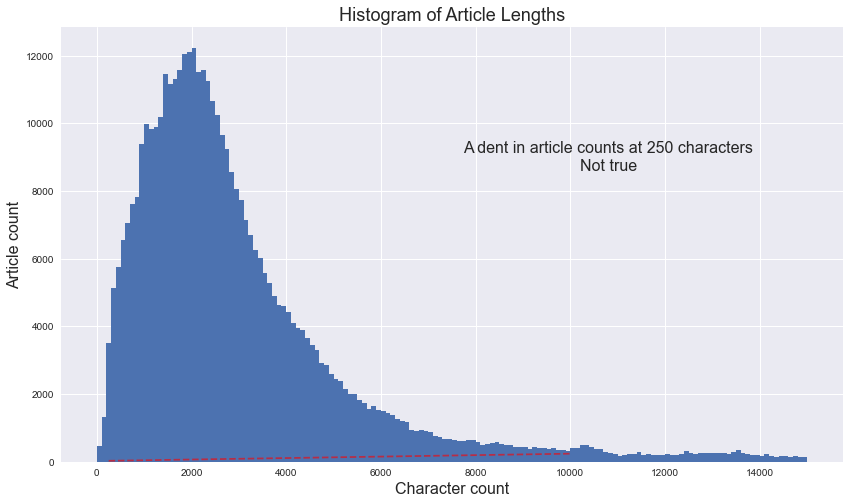

In [144]:
body_lengths = data['Body'].str.len()

desc = "A dent in article counts at 250 characters\nNot true"

y, bin_edges = np.histogram(body_lengths, bins=150, range=(0,15000))
x = 0.5*(bin_edges[1:] + bin_edges[:-1])

fig, ax = plt.subplots(1, figsize=(14,8))
plt.bar(x,y,width=np.diff(bin_edges))
plt.title("Histogram of Article Lengths", fontsize=18)
plt.xlabel("Character count", fontsize=16)
plt.ylabel("Article count", fontsize=16)
plt.text(0.7, 0.7, desc, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes, fontsize=16)
plt.plot([250,10000], [30,240], '--', c='red', alpha=.6)
#Ændr, så det passer med den endelige data.

### Author contributions
How many articles have the authors written?

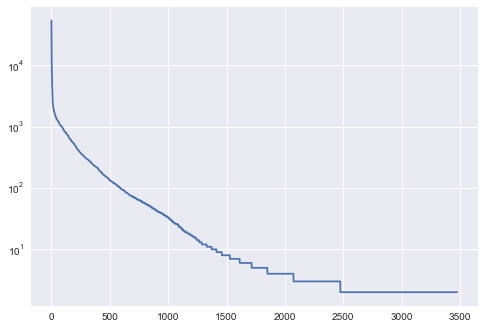

In [255]:
counts = list(data['Byline'].value_counts())

plt.plot(counts)
plt.yscale('symlog')

In [257]:
10**1

10

In [242]:
data['Byline'].value_counts()>2

Mads Elkær                  True
Anne Sophia Hermansen       True
Karim Pedersen              True
Thomas Treo                 True
Dan Jensen                  True
                           ...  
Peter Foder                False
Lars Skovgaard Andersen    False
Hans Andersen              False
Henrik Ræder Clausen       False
Andreas Graae              False
Name: Byline, Length: 3477, dtype: bool

In [243]:
data['Byline'].value_counts()[data['Byline'].value_counts()>2]

Mads Elkær                           53835
Anne Sophia Hermansen                15481
Karim Pedersen                       14066
Thomas Treo                           9434
Dan Jensen                            6915
                                     ...  
Thomas Flensburg | Mikkel Thuesen        3
Steffen Rasmussen                        3
Signe Skov,Emma B.Vinkel                 3
Camilla Stampe                           3
Jan Søgaard,Andreas F. R. Wentoft        3
Name: Byline, Length: 2475, dtype: int64